In [1]:
cov_neg = 'Train/Negatives/acute-respiratory-distress-syndrome-ards.jpg'

cov_pos = 'Train/Positives/1-s2.0-S0140673620303706-fx1_lrg.jpg'

test_images = 'Test/Negatives'
train_images = 'Train'
val_images  = 'Validation'

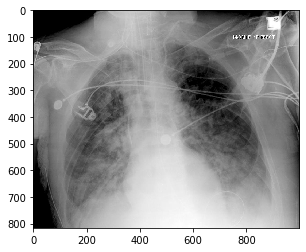

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

img = mpimg.imread(cov_neg)
#imgplot = plt.imshow(img, cmap = 'gray')
imgplot = plt.imshow(img)

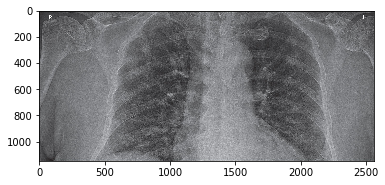

In [3]:
img = mpimg.imread(cov_pos)
imgplot = plt.imshow(img)

In [4]:
#Peprocessing and Augmenting Dataset Images 

#import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (64, 64)
datagen = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)


train_generator = datagen.flow_from_directory(
        train_images,
        target_size=IMG_SIZE,
        color_mode = 'grayscale',
        batch_size=4,
        class_mode='binary')

x_val, y_val = next(datagen.flow_from_directory(
        val_images,
        target_size=IMG_SIZE,
        color_mode = 'grayscale',
        batch_size=4,
        class_mode='binary')) # one big batch

x_test, y_test = next(datagen.flow_from_directory(
        test_images,
        target_size=IMG_SIZE,
        color_mode = 'grayscale',
        batch_size=40,
        class_mode='binary')) # one big batch


/home/aims/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/aims/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/aims/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/aims/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWa

Found 167 images belonging to 3 classes.
Found 39 images belonging to 2 classes.
Found 0 images belonging to 0 classes.


In [5]:
train_generator = datagen.flow_from_directory(
        'Train',
        target_size=IMG_SIZE,
        color_mode = 'grayscale',
        batch_size=4,
        class_mode='binary')

x_val, y_val = next(datagen.flow_from_directory(
        'Validation',
        target_size=IMG_SIZE,
        color_mode = 'grayscale',
        batch_size=4,
        class_mode='binary')) # one big batch

x_test, y_test = next(datagen.flow_from_directory(
        'Test',
        target_size=IMG_SIZE,
        color_mode = 'grayscale',
        batch_size=40,
        class_mode='binary')) # one big batch

Found 167 images belonging to 3 classes.
Found 39 images belonging to 2 classes.
Found 40 images belonging to 1 classes.


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten

model = Sequential()
model.add(Conv2D(32, (3, 3), activation="relu", input_shape=x_test.shape[1:]))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
__________________________________________

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('cov19_cnn')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5)
callbacks_list = [checkpoint, early]

In [8]:
#First Round 
model.fit_generator(train_generator, 
                    steps_per_epoch=100, 
                    validation_data = (x_val, y_val), 
                    epochs = 1, 
                    callbacks = callbacks_list)

   
# Save the entire model as a SavedModel
model.save('cov19_cnn') 

 99/100 [============================>.] - ETA: 0s - loss: 0.7136 - binary_accuracy: 0.7208 - mean_absolute_error: 0.3956
Epoch 00001: val_loss improved from inf to 0.56547, saving model to cov19_cnn_weights.best.hdf5
100/100 [==============================] - 12s 117ms/step - loss: 0.7143 - binary_accuracy: 0.7186 - mean_absolute_error: 0.3968 - val_loss: 0.5655 - val_binary_accuracy: 0.7500 - val_mean_absolute_error: 0.4093


In [9]:
scores = model.evaluate(x_test, y_test)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("val_loss:", scores[0])
print("val_mean_absolute_error:", scores[2])


40/40 [==============================] - 0s 314us/sample - loss: 1.0152 - binary_accuracy: 0.0000e+00 - mean_absolute_error: 0.6353
binary_accuracy: 0.00%
val_loss: 1.0152481079101563
val_mean_absolute_error: 0.63526154


In [10]:
# Continued Training
model.fit_generator(train_generator, 
                    steps_per_epoch=100, 
                    validation_data = (x_val, y_val), 
                    epochs = 11, 
                    callbacks = callbacks_list)

Epoch 1/11
 99/100 [============================>.] - ETA: 0s - loss: 0.5976 - binary_accuracy: 0.7277 - mean_absolute_error: 0.4026
Epoch 00001: val_loss did not improve from 0.56547
100/100 [==============================] - 12s 121ms/step - loss: 0.5976 - binary_accuracy: 0.7280 - mean_absolute_error: 0.4024 - val_loss: 0.6171 - val_binary_accuracy: 0.7500 - val_mean_absolute_error: 0.3900
Epoch 2/11
 99/100 [============================>.] - ETA: 0s - loss: 0.5633 - binary_accuracy: 0.7386 - mean_absolute_error: 0.3761
Epoch 00002: val_loss improved from 0.56547 to 0.53537, saving model to cov19_cnn_weights.best.hdf5
100/100 [==============================] - 12s 123ms/step - loss: 0.5602 - binary_accuracy: 0.7412 - mean_absolute_error: 0.3745 - val_loss: 0.5354 - val_binary_accuracy: 0.7500 - val_mean_absolute_error: 0.3148
Epoch 3/11
 98/100 [============================>.] - ETA: 0s - loss: 0.5581 - binary_accuracy: 0.7385 - mean_absolute_error: 0.3689
Epoch 00003: val_loss did 

In [11]:
model.load_weights(weight_path)
scores = model.evaluate(x_test, y_test)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("val_loss:", scores[0])
print("val_mean_absolute_error:", scores[2])

40/40 [==============================] - 0s 299us/sample - loss: 1.9365 - binary_accuracy: 0.0000e+00 - mean_absolute_error: 0.7929
binary_accuracy: 0.00%
val_loss: 1.936522626876831
val_mean_absolute_error: 0.7929264


In [12]:
pred_Y = model.predict(x_test, batch_size = 32, verbose = True)
print(pred_Y[:15])

40/40 [==============================] - 0s 628us/sample
[[0.8080249 ]
 [0.9931146 ]
 [0.60070825]
 [0.7172492 ]
 [0.9415496 ]
 [0.6638005 ]
 [0.71199614]
 [0.6978247 ]
 [0.86297345]
 [0.98025835]
 [0.9990885 ]
 [0.91232646]
 [0.90688735]
 [0.78718424]
 [0.6206466 ]]


In [13]:
print(y_test[:15])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


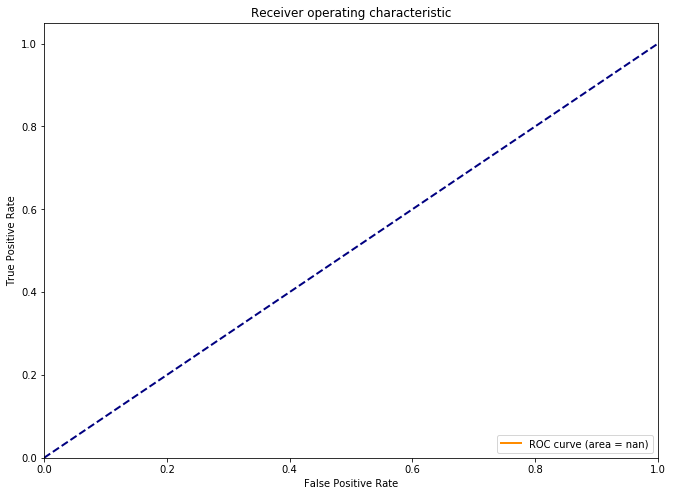

In [14]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class

num_classes = 0

fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(y_test, pred_Y)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(11,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange', 
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('roc2.png')

In [15]:
import pandas as pd
import numpy as np
df = pd.DataFrame(pred_Y)
df['Prediction']= np.where((df[0])>0.5, 'Negative', 'Positive')

In [16]:
# Save the data
df['Prediction'].to_csv('predictions.csv', index = False)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  
